<a href="https://colab.research.google.com/github/AadeshY/HSI-Denoising/blob/main/Hyperspectral_Restroration.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# ----------------------------
# 3. Configure Logging
# ----------------------------
import warnings
import logging
logging.basicConfig(level=logging.INFO, format='%(levelname)s: %(message)s')

# Import TFPNP model from its repository
try:
    from TFPnP.tfpnp.pnp.denoiser.models.unet import UNet as tfpnp
except ImportError:
    logging.warning("TFPNP module not found. Using placeholder. Please ensure TFPNP is installed correctly.")
    TFPnP = None
    tfpnp = None


Loading Indian Pines dataset...
Original Dataset Shape: (145, 145, 200)
Using cuda device
Logging to ./ppo_tfpnp_tensorboard/PPO_1
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 1        |
|    ep_rew_mean     | 16.3     |
| time/              |          |
|    fps             | 8        |
|    iterations      | 1        |
|    time_elapsed    | 231      |
|    total_timesteps | 2048     |
---------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1           |
|    ep_rew_mean          | 16.3        |
| time/                   |             |
|    fps                  | 8           |
|    iterations           | 2           |
|    time_elapsed         | 488         |
|    total_timesteps      | 4096        |
| train/                  |             |
|    approx_kl            | 0.003483779 |
|    clip_fraction        | 0.0157      |
|    clip_range          

            PSNR     SSIM        SAM
TFPNP   4.534696  0.29284  36.283128
BM3D   20.101047  0.00000  20.527296


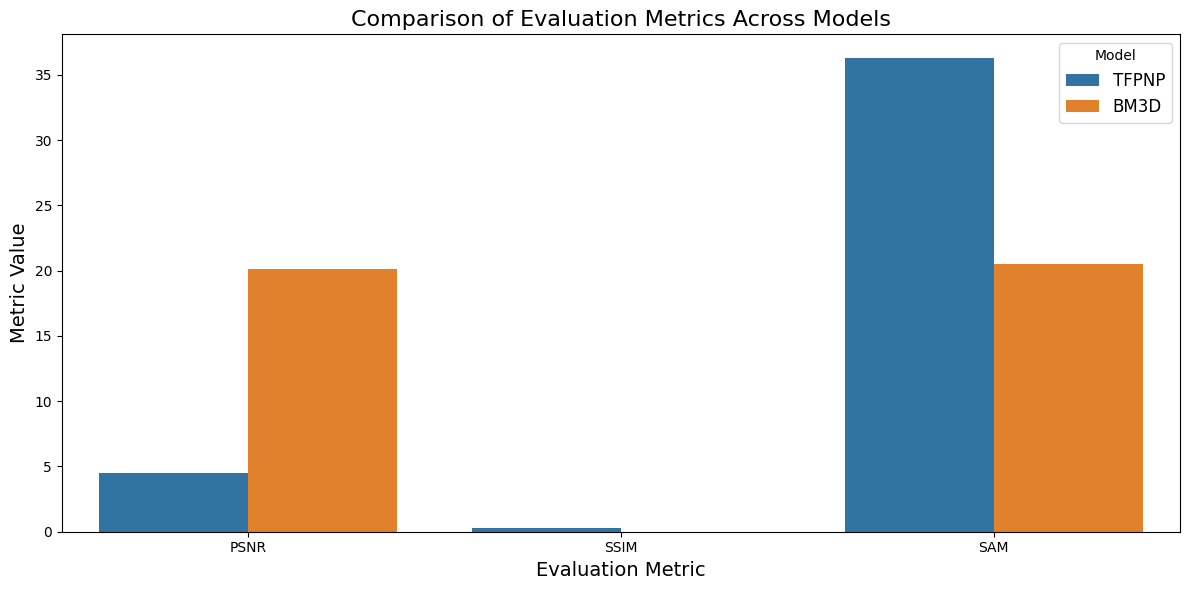

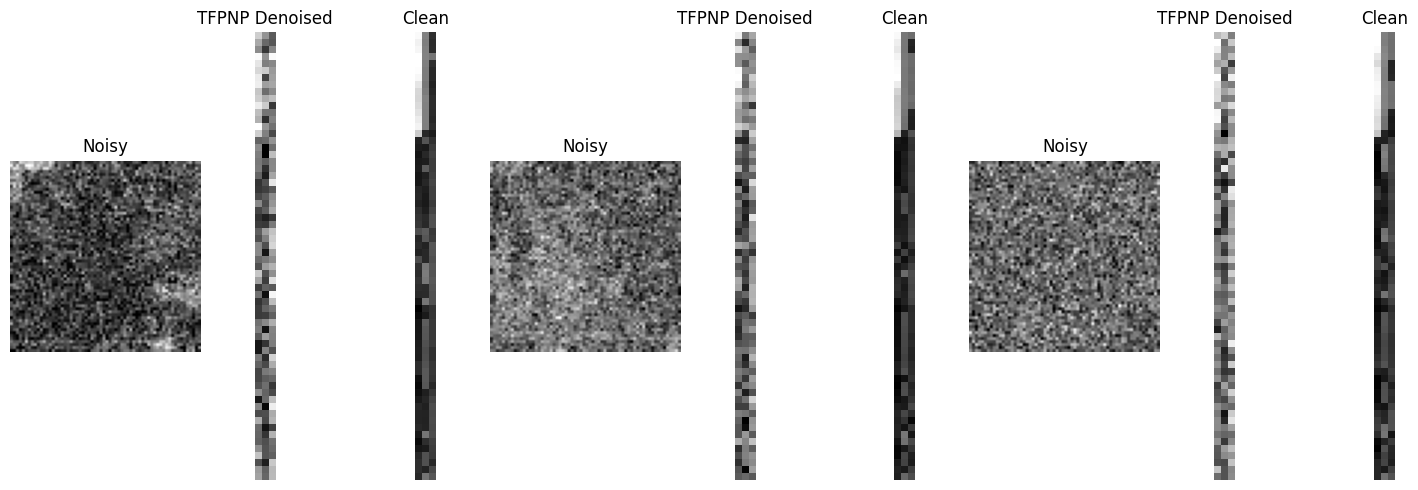

Logging to ./ppo_tfpnp_tensorboard/PPO_2
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 1        |
|    ep_rew_mean     | 16.4     |
| time/              |          |
|    fps             | 6        |
|    iterations      | 1        |
|    time_elapsed    | 327      |
|    total_timesteps | 2048     |
---------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1           |
|    ep_rew_mean          | 16.4        |
| time/                   |             |
|    fps                  | 6           |
|    iterations           | 2           |
|    time_elapsed         | 674         |
|    total_timesteps      | 4096        |
| train/                  |             |
|    approx_kl            | 0.004412666 |
|    clip_fraction        | 0.019       |
|    clip_range           | 0.2         |
|    entropy_loss         | -4.15       |
|    explained_variance   | 5.9

In [ ]:
# ----------------------------
# 2. Import Required Libraries
# ----------------------------
import os
import sys
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from skimage.metrics import peak_signal_noise_ratio as psnr
from skimage.metrics import structural_similarity as ssim
import scipy.io
from bm3d import bm3d as bm3d_denoise  # Correctly imported bm3d with alias
import gymnasium as gym
from gymnasium import spaces
from stable_baselines3 import PPO
from stable_baselines3.common.vec_env import DummyVecEnv
from stable_baselines3.common.monitor import Monitor
import logging
import copy
from functools import partial
import random
import gc
import warnings
warnings.filterwarnings("ignore")
import logging

# ----------------------------
# 3. Configure Logging
# ----------------------------
logging.basicConfig(level=logging.INFO, format='%(levelname)s: %(message)s')

# Import TFPNP model from its repository
try:
    from TFPnP.tfpnp.pnp.denoiser.models.unet import UNet as tfpnp
except ImportError:
    logging.warning("TFPNP module not found. Using placeholder. Please ensure TFPNP is installed correctly.")
    TFPnP = None
    tfpnp = None


# ----------------------------
# 4. Define Helper Functions
# ----------------------------
def compute_sam(ground_truth, denoised):
    """
    Compute Spectral Angle Mapper (SAM) between ground truth and denoised images.

    Parameters:
        ground_truth (numpy.ndarray): Ground truth image with shape [H, W, C].
        denoised (numpy.ndarray): Denoised image with shape [H, W, C].

    Returns:
        float: Average SAM over all valid pixels in degrees.
    """
    ground_truth = ground_truth.astype(np.float32)
    denoised = denoised.astype(np.float32)

    numerator = np.sum(ground_truth * denoised, axis=2)
    denominator = np.linalg.norm(ground_truth, axis=2) * np.linalg.norm(denoised, axis=2)

    # Avoid division by zero by creating a mask
    valid = denominator > 0
    sam_map = np.zeros_like(numerator)

    # Compute SAM only for valid pixels
    sam_map[valid] = np.arccos(np.clip(numerator[valid] / denominator[valid], -1, 1))

    # Handle NaNs by setting them to zero
    sam_map = np.nan_to_num(sam_map)

    return np.mean(sam_map) * (180 / np.pi)  # Convert to degrees

def visualize_results(noisy, clean, denoised_tfpnp, sample=0, bands=[0,1,2]):
    """
    Visualize the noisy, denoised, and clean images for a specific sample and bands.

    Parameters:
        noisy (numpy.ndarray): Noisy image batches with shape [B, C, H, W].
        clean (numpy.ndarray): Clean image batches with shape [B, C, H, W].
        denoised_tfpnp (numpy.ndarray): TFPNP denoised images with shape [B, C, H, W].
        sample (int): Index of the sample in the batch to visualize.
        bands (list): List of band indices to visualize.
    """
    num_bands = len(bands)
    plt.figure(figsize=(15, 5))

    for i, band in enumerate(bands):
        plt.subplot(1, num_bands * 3, i * 3 + 1)
        plt.imshow(noisy[sample, band, :, :], cmap='gray')
        plt.title('Noisy')
        plt.axis('off')

        plt.subplot(1, num_bands * 3, i * 3 + 2)
        plt.imshow(denoised_tfpnp[sample, band, :, :], cmap='gray')
        plt.title('TFPNP Denoised')
        plt.axis('off')

        plt.subplot(1, num_bands * 3, i * 3 + 3)
        plt.imshow(clean[sample, band, :, :], cmap='gray')
        plt.title('Clean')
        plt.axis('off')

    plt.tight_layout()
    plt.show()

def visualize_batch_samples(noisy, clean, denoised_tfpnp, bands=[0,1,2], num_samples=3):
    """
    Visualize noisy, denoised, and clean images for multiple samples and specified bands.

    Parameters:
        noisy (numpy.ndarray): Noisy image batches with shape [B, C, H, W].
        clean (numpy.ndarray): Clean image batches with shape [B, C, H, W].
        denoised_tfpnp (numpy.ndarray): TFPNP denoised images with shape [B, C, H, W].
        bands (list): List of band indices to visualize.
        num_samples (int): Number of samples in the batch to visualize.
    """
    num_bands = len(bands)
    plt.figure(figsize=(20, 5 * num_samples))

    for sample_idx in range(num_samples):
        for i, band in enumerate(bands):
            plt.subplot(num_samples, num_bands * 3, sample_idx * num_bands * 3 + i * 3 + 1)
            plt.imshow(noisy[sample_idx, band, :, :], cmap='gray')
            plt.title(f"Noisy - Sample {sample_idx + 1} - Band {band}")
            plt.axis('off')

            plt.subplot(num_samples, num_bands * 3, sample_idx * num_bands * 3 + i * 3 + 2)
            plt.imshow(denoised_tfpnp[sample_idx, band, :, :], cmap='gray')
            plt.title(f"TFPNP Denoised - Sample {sample_idx + 1} - Band {band}")
            plt.axis('off')

            plt.subplot(num_samples, num_bands * 3, sample_idx * num_bands * 3 + i * 3 + 3)
            plt.imshow(clean[sample_idx, band, :, :], cmap='gray')
            plt.title(f"Clean - Sample {sample_idx + 1} - Band {band}")
            plt.axis('off')

    plt.tight_layout()
    plt.show()

def save_visualization(noisy, clean, denoised_tfpnp, bands=[0,1,2], sample_idx=0, filename='denoising_result.png'):
    """
    Save the visualization of noisy, denoised, and clean images for specified bands of a single sample.

    Parameters:
        noisy (numpy.ndarray): Noisy image batches with shape [B, C, H, W].
        clean (numpy.ndarray): Clean image batches with shape [B, C, H, W].
        denoised_tfpnp (numpy.ndarray): TFPNP denoised images with shape [B, C, H, W].
        bands (list): List of band indices to visualize.
        sample_idx (int): Index of the sample in the batch to visualize.
        filename (str): Filename to save the visualization.
    """
    num_bands = len(bands)
    plt.figure(figsize=(15, 5))

    for i, band in enumerate(bands):
        plt.subplot(1, num_bands * 3, i * 3 + 1)
        plt.imshow(noisy[sample_idx, band, :, :], cmap='gray')
        plt.title(f"Noisy - Band {band}")
        plt.axis('off')

        plt.subplot(1, num_bands * 3, i * 3 + 2)
        plt.imshow(denoised_tfpnp[sample_idx, band, :, :], cmap='gray')
        plt.title(f"TFPNP Denoised - Band {band}")
        plt.axis('off')

        plt.subplot(1, num_bands * 3, i * 3 + 3)
        plt.imshow(clean[sample_idx, band, :, :], cmap='gray')
        plt.title(f"Clean - Band {band}")
        plt.axis('off')

    plt.tight_layout()
    plt.savefig(filename, dpi=300)
    plt.close()

# ----------------------------
# 5. Define Dataset Class
# ----------------------------
class HSIDataset(Dataset):
    def __init__(self, noisy_patches, clean_patches, augment=False):
        """
        Hyperspectral Image Dataset.

        Parameters:
            noisy_patches (numpy.ndarray): Noisy image patches with shape [N, H, W, C].
            clean_patches (numpy.ndarray): Clean image patches with shape [N, H, W, C].
            augment (bool): Whether to apply data augmentation.
        """
        self.noisy_patches = noisy_patches
        self.clean_patches = clean_patches
        self.augment = augment
        if self.augment:
            self.transform = transforms.Compose([
                transforms.ToPILImage(),
                transforms.RandomHorizontalFlip(),
                transforms.RandomVerticalFlip(),
                transforms.RandomRotation(90),
                transforms.ToTensor(),
            ])
        else:
            self.transform = None

    def __len__(self):
        return len(self.noisy_patches)

    def __getitem__(self, idx):
        noisy = self.noisy_patches[idx]  # [H, W, C]
        clean = self.clean_patches[idx]  # [H, W, C]
        if self.augment:
            # Apply the same transformation to both noisy and clean patches
            seed = np.random.randint(2147483647)  # Get a random seed
            torch.manual_seed(seed)
            noisy_tensor = torch.from_numpy(noisy).permute(2, 0, 1)  # [C, H, W]
            clean_tensor = torch.from_numpy(clean).permute(2, 0, 1)  # [C, H, W]
            noisy_transformed = self.transform(noisy_tensor)
            clean_transformed = self.transform(clean_tensor)
            # Transpose back to [H, W, C]
            noisy = noisy_transformed.permute(1, 2, 0).numpy()
            clean = clean_transformed.permute(1, 2, 0).numpy()
        else:
            # No augmentation; ensure data is in [H, W, C] format
            noisy = noisy.astype(np.float32)
            clean = clean.astype(np.float32)
        return noisy, clean

# ----------------------------
# 6. Data Preparation Functions
# ----------------------------
def download_and_preprocess_data(noise_type='gaussian', noise_params={}):
    """
    Download, normalize, and preprocess the Indian Pines dataset.

    Parameters:
        noise_type (str): Type of noise to add ('gaussian', 'salt_pepper').
        noise_params (dict): Parameters for the noise type.

    Returns:
        patches_noisy (numpy.ndarray): Noisy image patches with shape [N, H, W, C].
        patches_clean (numpy.ndarray): Clean image patches with shape [N, H, W, C].
    """
    # Download the Indian Pines dataset if not already present
    dataset_url = "http://www.ehu.eus/ccwintco/uploads/6/67/Indian_pines_corrected.mat"
    dataset_path = "indian_pines_corrected.mat"
    if not os.path.exists(dataset_path):
        print(f"Downloading dataset from {dataset_url}...")
        os.system(f"wget '{dataset_url}' -O {dataset_path}")

    # Load and normalize the dataset
    print("Loading Indian Pines dataset...")
    data = scipy.io.loadmat(dataset_path)
    hsi = data['indian_pines_corrected'].astype('float32')
    hsi_normalized = (hsi - hsi.min()) / (hsi.max() - hsi.min())
    print("Original Dataset Shape:", hsi_normalized.shape)

    # Select specific channels (e.g., channels 29, 60, 90)
    selected_channels = [29, 60, 90]  # Adjust based on actual channel indexing (0-based)
    hsi_selected = hsi_normalized[:, :, selected_channels]
    logging.info(f"Dataset Shape After Channel Selection: {hsi_selected.shape}")  # [H, W, C=3]

    # Add specified noise type
    logging.info(f"Adding {noise_type} noise to dataset...")
    noisy_hsi = add_noise(hsi_selected, noise_type=noise_type, **noise_params)
    logging.info("Noise added and data clipped to [0,1].")

    # Extract patches
    logging.info("Extracting patches...")
    patches_noisy = extract_patches(noisy_hsi, patch_size=64, stride=16)  # [N, H, W, C]
    patches_clean = extract_patches(hsi_selected, patch_size=64, stride=16)  # [N, H, W, C]
    logging.info(f"Total patches extracted: {len(patches_noisy)}")
    return patches_noisy, patches_clean

def extract_patches(data, patch_size=64, stride=16):
    """
    Extract overlapping patches from the data.

    Parameters:
        data (numpy.ndarray): Input data with shape [H, W, C].
        patch_size (int): Size of each patch.
        stride (int): Stride for patch extraction.

    Returns:
        patches (numpy.ndarray): Extracted patches with shape [N, H, W, C].
    """
    patches = []
    h, w = data.shape[:2]
    for i in range(0, h - patch_size + 1, stride):
        for j in range(0, w - patch_size + 1, stride):
            patch = data[i:i + patch_size, j:j + patch_size]
            if patch.shape[0] == patch_size and patch.shape[1] == patch_size:
                patches.append(patch)
    patches = np.array(patches)

    # Assert that all patches are of correct size
    assert patches.shape[1] == patch_size and patches.shape[2] == patch_size, "One or more patches are smaller than the patch size."

    return patches

def add_noise(data, noise_type='gaussian', **kwargs):
    """
    Add different types of noise to the data.

    Parameters:
        data (numpy.ndarray): Original clean data with shape [H, W, C].
        noise_type (str): Type of noise ('gaussian', 'salt_pepper', etc.).
        **kwargs: Additional parameters for noise types.

    Returns:
        noisy_data (numpy.ndarray): Data with added noise.
    """
    if noise_type == 'gaussian':
        noise_std = kwargs.get('noise_std', 0.1)
        noisy_data = data + noise_std * np.random.randn(*data.shape)
        noisy_data = np.clip(noisy_data, 0, 1)
    elif noise_type == 'salt_pepper':
        amount = kwargs.get('amount', 0.05)
        noisy_data = data.copy()
        num_salt = np.ceil(amount * data.size * 0.5).astype(int)
        num_pepper = np.ceil(amount * data.size * 0.5).astype(int)
        # Salt
        coords = [np.random.randint(0, i, num_salt) for i in data.shape]
        noisy_data[tuple(coords)] = 1
        # Pepper
        coords = [np.random.randint(0, i, num_pepper) for i in data.shape]
        noisy_data[tuple(coords)] = 0
    else:
        raise ValueError("Unsupported noise type.")
    return noisy_data

# ----------------------------
# 7. Define Denoiser Models
# ----------------------------
# Assuming TFPNP is correctly installed and imported
# If TFPNP is not defined, use a placeholder denoiser
from TFPnP.tfpnp.pnp.denoiser.models.unet import UNet

if TFPnP is not None:
    class TFPnPDenoiser(nn.Module):
        def __init__(self, in_channels=3, out_channels=3):
            super(TFPnPDenoiser, self).__init__()
            self.model = UNet(in_channels=in_channels, out_channels=out_channels)

        def forward(self, x):
            return self.model(x)
else:
    # Placeholder denoiser (Residual UNet)
    class ResidualBlock(nn.Module):
        def __init__(self, in_channels, out_channels):
            super(ResidualBlock, self).__init__()
            self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1)
            self.bn1   = nn.BatchNorm2d(out_channels)
            self.relu  = nn.ReLU(inplace=True)
            self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1)
            self.bn2   = nn.BatchNorm2d(out_channels)

            if in_channels != out_channels:
                self.residual = nn.Conv2d(in_channels, out_channels, kernel_size=1)
            else:
                self.residual = nn.Identity()

        def forward(self, x):
            identity = self.residual(x)
            out = self.relu(self.bn1(self.conv1(x)))
            out = self.bn2(self.conv2(out))
            out += identity
            out = self.relu(out)
            return out

    class ResidualUNetDenoiser(nn.Module):
        def __init__(self, n_channels=3, n_classes=3, bilinear=True):
            super(ResidualUNetDenoiser, self).__init__()
            self.n_channels = n_channels
            self.n_classes  = n_classes
            self.bilinear   = bilinear

            # Encoder
            self.inc = ResidualBlock(n_channels, 64)
            self.down1 = Down(64, 128)
            self.down2 = Down(128, 256)
            self.down3 = Down(256, 512)
            factor = 2 if bilinear else 1
            self.down4 = Down(512, 1024 // factor)

            # Decoder
            self.up1 = Up(1024, 512 // factor, bilinear)
            self.up2 = Up(512, 256 // factor, bilinear)
            self.up3 = Up(256, 128 // factor, bilinear)
            self.up4 = Up(128, 64, bilinear)
            self.outc = OutConv(64, n_classes)
            self.sigmoid = nn.Sigmoid()  # Clamp outputs to [0,1]

        def forward(self, x):
            x1 = self.inc(x)          # [B, 64, H, W]
            x2 = self.down1(x1)       # [B, 128, H/2, W/2]
            x3 = self.down2(x2)       # [B, 256, H/4, W/4]
            x4 = self.down3(x3)       # [B, 512, H/8, W/8]
            x5 = self.down4(x4)       # [B, 1024, H/16, W/16]
            x = self.up1(x5, x4)      # [B, 512, H/8, W/8]
            x = self.up2(x, x3)       # [B, 256, H/4, W/4]
            x = self.up3(x, x2)       # [B, 128, H/2, W/2]
            x = self.up4(x, x1)       # [B, 64, H, W]
            logits = self.outc(x)     # [B, 3, H, W]
            # Removed incorrect assertion
            # assert logits.shape == x.shape, f"Output shape {logits.shape} does not match input shape {x.shape}"
            return self.sigmoid(logits)

    # Define Down, Up, OutConv classes used in ResidualUNetDenoiser
    class DoubleConv(nn.Module):
        """Applies two consecutive convolutional layers each followed by ReLU activation."""
        def __init__(self, in_channels, out_channels):
            super(DoubleConv, self).__init__()
            self.double_conv = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),  # Padding to maintain spatial dimensions
                nn.ReLU(inplace=True),
                nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
                nn.ReLU(inplace=True)
            )

        def forward(self, x):
            return self.double_conv(x)

    class Down(nn.Module):
        """Downscaling with maxpool followed by double convolution."""
        def __init__(self, in_channels, out_channels):
            super(Down, self).__init__()
            self.maxpool_conv = nn.Sequential(
                nn.MaxPool2d(2),  # Reduces spatial dimensions by a factor of 2
                DoubleConv(in_channels, out_channels)
            )

        def forward(self, x):
            return self.maxpool_conv(x)

    class Up(nn.Module):
        """Upscaling followed by double convolution."""
        def __init__(self, in_channels, out_channels, bilinear=True):
            super(Up, self).__init__()

            # If bilinear, use the normal convolutions to reduce the number of channels after upsampling
            if bilinear:
                self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
                self.conv = DoubleConv(in_channels, out_channels)
            else:
                # Learnable up-convolution
                self.up = nn.ConvTranspose2d(in_channels // 2, in_channels // 2, kernel_size=2, stride=2)
                self.conv = DoubleConv(in_channels, out_channels)

        def forward(self, x1, x2):
            x1 = self.up(x1)

            # Input is CHW
            diffY = x2.size()[2] - x1.size()[2]
            diffX = x2.size()[3] - x1.size()[3]

            # Padding to handle any mismatch in dimensions
            x1 = nn.functional.pad(x1, [diffX // 2, diffX - diffX // 2,
                                        diffY // 2, diffY - diffY // 2])

            # Concatenate along the channels axis
            x = torch.cat([x2, x1], dim=1)
            return self.conv(x)

    class OutConv(nn.Module):
        """Final convolution to map to the desired number of output channels."""
        def __init__(self, in_channels, out_channels):
            super(OutConv, self).__init__()
            self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=1)

        def forward(self, x):
            return self.conv(x)

# ----------------------------
# 8. Define ADMM Solver with Enhancements
# ----------------------------
class ADMMSolver(nn.Module):
    def __init__(self, denoiser, max_iterations=10):
        """
        ADMM Solver integrating the denoiser within an iterative optimization framework.

        Parameters:
            denoiser (nn.Module): Denoising neural network.
            max_iterations (int): Maximum number of ADMM iterations.
        """
        super(ADMMSolver, self).__init__()
        self.denoiser = denoiser
        self.max_iterations = max_iterations
        self.is_3d = self.check_if_3d()

    def check_if_3d(self):
        """
        Check if the denoiser contains any 3D convolutional layers.

        Returns:
            bool: True if 3D convolutions are present, False otherwise.
        """
        for layer in self.denoiser.modules():
            if isinstance(layer, nn.Conv3d):
                return True
        return False

    def forward(self, noisy, params, iterations=None):
        """
        Forward pass through the ADMM Solver.

        Parameters:
            noisy (torch.Tensor): Noisy input image tensor with shape [B, C, H, W].
            params (torch.Tensor): Parameters tensor containing sigma_d and mu with shape [B, 2].
            iterations (int or list, optional): Number of ADMM iterations. If int, applies to all samples.
                                               If list, applies per sample. Defaults to self.max_iterations.

        Returns:
            torch.Tensor: Denoised image tensor with shape [B, C, H, W].
        """
        if iterations is None:
            iterations = self.max_iterations

        x = noisy.clone()
        z = noisy.clone()
        u = torch.zeros_like(noisy)

        # params shape: [batch_size, 2]
        sigma_d = params[:, 0].view(-1, 1, 1, 1)  # [B, 1, 1, 1]
        mu = params[:, 1].view(-1, 1, 1, 1)       # [B, 1, 1, 1]

        if isinstance(iterations, list):
            max_iter = max(iterations)
        else:
            max_iter = iterations

        for iter_num in range(max_iter):
            if self.is_3d:
                # Reshape to [B, C, D, H, W]
                x_input = z - u
                x_input = x_input.unsqueeze(2)  # [B, C, 1, H, W]
                denoised = self.denoiser(x_input)
                denoised = denoised.squeeze(2)  # [B, C, H, W]
            else:
                denoised = self.denoiser(z - u)  # [B, C, H, W]

            # Update variables
            x = denoised  # Update x
            z = (x + u) / (1 + mu)  # Update z
            u = u + (x - z)         # Update u

        return x  # [B, C, H, W]

# ----------------------------
# 9. Define RL Environment
# ----------------------------
class ADMMEnv(gym.Env):
    """
    Custom Environment for ADMM Solver with RL-based parameter tuning.
    """
    def __init__(self, model, device, test_loader, max_iterations=10):
        super(ADMMEnv, self).__init__()
        self.model = model
        self.device = device
        self.test_loader = test_loader
        self.max_iterations = max_iterations
        self.current_step = 0
        self.total_psnr = 0
        self.data_iter = iter(self.test_loader)
        # Observation Space: Simplified to current PSNR
        self.observation_space = spaces.Box(
            low=np.array([0.0], dtype=np.float32),
            high=np.array([100.0], dtype=np.float32),
            shape=(1,),
            dtype=np.float32
        )
        # Action Space: [sigma_d, mu, tau]
        self.action_space = spaces.Box(
            low=np.array([0.0, 0.0, 1], dtype=np.float32),
            high=np.array([1.0, 1.0, self.max_iterations], dtype=np.float32),
            dtype=np.float32
        )

    def reset(self, seed=None, options=None):
        super().reset(seed=seed)
        self.current_step = 0
        self.total_psnr = 0
        initial_psnr = 0.0
        observation = np.array([initial_psnr], dtype=np.float32)
        info = {}
        return observation, info

    def step(self, action):
        sigma_d, mu, tau = action
        sigma_d = np.clip(sigma_d, 0.0, 1.0)
        mu = np.clip(mu, 0.0, 1.0)
        tau = int(np.clip(tau, 1, self.max_iterations))

        params = torch.tensor([[sigma_d, mu]], dtype=torch.float32).to(self.device)

        # Get one batch from test_loader
        try:
            noisy, clean = next(self.data_iter)
        except StopIteration:
            self.data_iter = iter(self.test_loader)
            noisy, clean = next(self.data_iter)

        noisy = noisy.to(self.device).permute(0, 3, 1, 2)  # [B, C, H, W]
        clean = clean.numpy()  # [B, H, W, C]

        denoised = self.model(noisy, params=params, iterations=tau)
        denoised = denoised.detach().cpu().numpy()  # [B, C, H, W]
        denoised = denoised.transpose(0, 2, 3, 1)   # [B, H, W, C]
        # Ensure clean is [B, H, W, C]
        # clean = clean.transpose(0, 2, 3, 1)         # [B, W, C, H]  # Removed

        # Assert that shapes match
        assert denoised.shape == clean.shape, f"Denoised shape {denoised.shape} does not match clean shape {clean.shape}"

        # Compute PSNR as reward for each sample and average
        batch_psnr = []
        for i in range(denoised.shape[0]):
            denoised_img = denoised[i]  # [H, W, C]
            clean_img = clean[i]        # [H, W, C]
            p = psnr(clean_img, denoised_img, data_range=1)
            batch_psnr.append(p)
        reward = np.mean(batch_psnr)
        self.current_psnr = reward

        done = True  # Episode ends after one step
        info = {}

        observation = np.array([self.current_psnr], dtype=np.float32)
        return observation, reward, done, False, info

    def render(self, mode='human'):
        pass  # Implement visualization if needed

    def close(self):
        pass  # Perform any necessary cleanup

def verify_denoiser(denoiser, device, test_loader):
    """
    Verifies that the denoiser model can process inputs and outputs valid results.

    Parameters:
        denoiser (nn.Module): The denoiser model to verify.
        device (torch.device): The device to run the verification on.
        test_loader (DataLoader): DataLoader for the test set.
    """
    denoiser.eval()  # Set model to evaluation mode
    try:
        # Fetch a batch from the test loader
        noisy, clean = next(iter(test_loader))
        noisy = noisy.to(device).permute(0, 3, 1, 2)  # [B, C, H, W]
        clean = clean.to(device).permute(0, 3, 1, 2)  # [B, C, H, W]

        # Pass through the denoiser
        with torch.no_grad():
            denoised = denoiser(noisy)

        # Ensure the output shape matches the input shape
        assert denoised.shape == clean.shape, f"Denoised output shape {denoised.shape} does not match clean shape {clean.shape}"

        logging.info("Denoiser verification passed: Model output matches expected dimensions.")
    except Exception as e:
        logging.error(f"Denoiser verification failed: {e}")
        raise e

# ----------------------------
# 10. Initialize Models and PPO Agents
# ----------------------------
def initialize_models_and_agents(device, test_loader):
    """
    Initialize denoiser models, ADMM solvers, environments, and PPO agents.

    Parameters:
        device (torch.device): Device to run computations on.
        test_loader (DataLoader): DataLoader for the test set.

    Returns:
        admm_tfpnp (ADMMSolver): ADMM Solver with TFPNP denoiser.
        ppo_tfpnp (PPO): PPO agent for TFPNP.
        optimizer_tfpnp (torch.optim.Optimizer): Optimizer for TFPNP.
    """
    if TFPnP is not None:
        # Initialize TFPNP's model
        tfpnp_model = TFPnPDenoiser(in_channels=3, out_channels=3).to(device)
    else:
        # Initialize placeholder denoiser
        tfpnp_model = ResidualUNetDenoiser(n_channels=3, n_classes=3).to(device)

    admm_tfpnp = ADMMSolver(denoiser=tfpnp_model, max_iterations=10).to(device)
    optimizer_tfpnp = optim.Adam(admm_tfpnp.parameters(), lr=1e-4, weight_decay=1e-5)  # Added weight decay for regularization

    # Define environment creation function
    env_tfpnp_fn = partial(ADMMEnv, admm_tfpnp, device, test_loader, max_iterations=10)

    # Initialize Environment with Correct Wrapping and Reduced num_workers
    env_tfpnp = DummyVecEnv([lambda: Monitor(env_tfpnp_fn())])

    # Initialize PPO Agent with Learning Rate Scheduler
    ppo_tfpnp = PPO('MlpPolicy', env_tfpnp, verbose=1, tensorboard_log="./ppo_tfpnp_tensorboard/", device=device)

    return admm_tfpnp, ppo_tfpnp, optimizer_tfpnp

# ----------------------------
# 11. Evaluation Functions
# ----------------------------
def evaluate_model(model, denoiser, device, test_loader):
    """
    Evaluate the ADMM Solver with a denoiser on the test set.

    Parameters:
        model (ADMMSolver): The ADMM Solver model.
        denoiser (nn.Module): The denoising neural network.
        device (torch.device): Device to run computations on.
        test_loader (DataLoader): DataLoader for the test set.

    Returns:
        mean_psnr, mean_ssim, mean_sam: Evaluation metrics.
    """
    model.eval()
    psnr_list, ssim_list, sam_list = [], [], []
    with torch.no_grad():
        for noisy, clean in test_loader:
            noisy = noisy.to(device).permute(0, 3, 1, 2)  # [B, C, H, W]
            clean = clean.numpy()  # [B, H, W, C]
            # Generate fixed parameters for evaluation (e.g., sigma_d=0.1, mu=0.1)
            params = torch.tensor([[0.1, 0.1]] * noisy.size(0), dtype=torch.float32).to(device)
            denoised = model(noisy, params=params, iterations=10)
            denoised = denoised.cpu().numpy()  # [B, C, H, W]
            denoised = denoised.transpose(0, 2, 3, 1)  # [B, H, W, C]
            # Ensure clean is [B, H, W, C]
            # clean = clean.transpose(0, 2, 3, 1)         # [B, W, C, H]  # Removed

            # Assert that shapes match
            assert denoised.shape == clean.shape, f"Denoised shape {denoised.shape} does not match clean shape {clean.shape}"

            # Compute PSNR, SSIM, SAM for each sample and accumulate
            for i in range(denoised.shape[0]):
                denoised_img = denoised[i]  # [H, W, C]
                clean_img = clean[i]        # [H, W, C]
                p = psnr(clean_img, denoised_img, data_range=1)
                try:
                    s = ssim(clean_img, denoised_img, data_range=1, channel_axis=-1, win_size=7)
                except ValueError as e:
                    logging.warning(f"SSIM error for sample {i}: {e}")
                    s = 0.0  # Assign a minimal SSIM if error occurs
                a = compute_sam(clean_img, denoised_img)
                psnr_list.append(p)
                ssim_list.append(s)
                sam_list.append(a)
    return np.mean(psnr_list), np.mean(ssim_list), np.mean(sam_list)

def evaluate_with_bm3d_alternative(test_loader, sigma=0.1):
    """
    Evaluate BM3D denoising on the test set using the bm3d package.

    Parameters:
        test_loader (DataLoader): DataLoader for the test set.
        sigma (float): Noise standard deviation.

    Returns:
        mean_psnr, mean_ssim, mean_sam: Evaluation metrics.
    """
    psnr_list, ssim_list, sam_list = [], [], []
    for noisy, clean in test_loader:
        noisy = noisy.numpy()  # [B, C, H, W]
        clean = clean.numpy()  # [B, C, H, W]
        denoised = []
        for i in range(noisy.shape[0]):
            try:
                denoised_img = bm3d_denoise_alternative(noisy[i].transpose(1,2,0), sigma)
                if denoised_img.ndim != 3 or denoised_img.shape[2] != 3:
                    raise ValueError(f"Denoised image has incorrect shape: {denoised_img.shape}")
                denoised.append(denoised_img)
            except ValueError as e:
                logging.warning(f"Skipping patch {i} due to error: {e}")
                denoised.append(noisy[i].transpose(1,2,0))  # Append noisy image if denoising fails
        denoised = np.array(denoised)
        for i in range(len(denoised)):
            clean_img = clean[i].transpose(1,2,0)         # [H, W, C]
            denoised_img = denoised[i]                   # [H, W, C]
            p = psnr(clean_img, denoised_img, data_range=1)
            try:
                s = ssim(clean_img, denoised_img, data_range=1, channel_axis=-1, win_size=7)
            except ValueError as e:
                logging.warning(f"SSIM error for BM3D sample {i}: {e}")
                s = 0.0
            a = compute_sam(clean_img, denoised_img)
            psnr_list.append(p)
            ssim_list.append(s)
            sam_list.append(a)
    return np.mean(psnr_list), np.mean(ssim_list), np.mean(sam_list)

def evaluate_models(models, model_names, device, test_loader):
    """
    Evaluate multiple models on the test set and compile their metrics.

    Parameters:
        models (list): List of models to evaluate.
        model_names (list): Corresponding names of the models.
        device (torch.device): Device to run computations on.
        test_loader (DataLoader): DataLoader for the test set.

    Returns:
        metrics_dict (dict): Dictionary containing metrics for each model.
    """
    metrics_dict = {}
    for model, name in zip(models, model_names):
        if name == 'BM3D':
            psnr_val, ssim_val, sam_val = evaluate_with_bm3d_alternative(test_loader, sigma=0.1)
        else:
            psnr_val, ssim_val, sam_val = evaluate_model(model, model.denoiser, device, test_loader)
        metrics_dict[name] = {'PSNR': psnr_val, 'SSIM': ssim_val, 'SAM': sam_val}
        logging.info(f"{name} Evaluation: PSNR: {psnr_val:.2f}, SSIM: {ssim_val:.4f}, SAM: {sam_val:.4f}")
    return metrics_dict

def generate_evaluation_table(metrics_dict):
    """
    Generate a pandas DataFrame from the metrics dictionary.

    Parameters:
        metrics_dict (dict): Dictionary containing metrics for each model.

    Returns:
        df (DataFrame): Pandas DataFrame with evaluation metrics.
    """
    df = pd.DataFrame(metrics_dict).T  # Transpose to have models as rows
    return df

def plot_metrics(df_metrics):
    """
    Plot evaluation metrics using seaborn.

    Parameters:
        df_metrics (DataFrame): DataFrame containing evaluation metrics.
    """
    df_melted = df_metrics.reset_index().melt(id_vars='index', var_name='Metric', value_name='Value')
    df_melted.rename(columns={'index': 'Model'}, inplace=True)

    plt.figure(figsize=(12, 6))
    sns.barplot(x='Metric', y='Value', hue='Model', data=df_melted)
    plt.title('Comparison of Evaluation Metrics Across Models', fontsize=16)
    plt.ylabel('Metric Value', fontsize=14)
    plt.xlabel('Evaluation Metric', fontsize=14)
    plt.legend(title='Model', fontsize=12)
    plt.tight_layout()
    plt.show()

# ----------------------------
# 12. BM3D Denoising Function (Alternative)
# ----------------------------
def bm3d_denoise_alternative(noisy_image, sigma):
    """
    Apply BM3D denoising using the bm3d package.

    Parameters:
        noisy_image (numpy.ndarray): Noisy image with shape (H, W, C).
        sigma (float): Noise standard deviation.

    Returns:
        denoised_image (numpy.ndarray): Denoised image.
    """
    denoised = np.zeros_like(noisy_image)
    for c in range(noisy_image.shape[2]):
        channel_data = noisy_image[:, :, c]
        h, w = channel_data.shape
        logging.debug(f"Denoising channel {c}: shape {h}x{w}")  # Debugging
        if h < 8 or w < 8:
            raise ValueError(f"Patch size for channel {c} is too small: {h}x{w}")
        denoised[:, :, c] = bm3d_denoise(channel_data, sigma)
    return denoised

# ----------------------------
# 13. Training Function with Enhancements
# ----------------------------
def train_models(admm_tfpnp, ppo_tfpnp, optimizer_tfpnp,
                train_loader, test_loader, device, epochs=50):
    """
    Train ADMM Solver with PPO agent focusing on TFPNP denoiser.

    Parameters:
        admm_tfpnp (ADMMSolver): ADMM Solver with TFPNP denoiser.
        ppo_tfpnp (PPO): PPO agent for TFPNP.
        optimizer_tfpnp (torch.optim.Optimizer): Optimizer for TFPNP.
        train_loader (DataLoader): DataLoader for the training set.
        test_loader (DataLoader): DataLoader for the test set.
        device (torch.device): Device to run computations on.
        epochs (int): Number of training epochs.

    Returns:
        None
    """
    # Initialize lists to track PPO agent's parameters
    sigma_d_values = []
    mu_values = []

    # Initialize lists to store metrics
    training_losses_tfpnp = []
    admm_psnr = []
    admm_ssim = []
    admm_sam = []
    bm3d_psnr = []
    bm3d_ssim = []
    bm3d_sam = []

    # Initialize learning rate schedulers
    scheduler_tfpnp = optim.lr_scheduler.ReduceLROnPlateau(optimizer_tfpnp, mode='min', factor=0.5, patience=5, verbose=True)

    # Combined Loss Function (MSE + SSIM + SAM)
    class CombinedLoss(nn.Module):
        def __init__(self, alpha=1.0, beta=1.0, gamma=1.0):
            super(CombinedLoss, self).__init__()
            self.alpha = alpha
            self.beta = beta
            self.gamma = gamma
            self.mse = nn.MSELoss()

        def forward(self, denoised, clean):
            mse_loss = self.mse(denoised, clean)
            # Compute SSIM loss
            denoised_np = denoised.detach().cpu().numpy()
            clean_np = clean.detach().cpu().numpy()
            ssim_loss = 0.0
            sam_loss = 0.0
            batch_size = denoised_np.shape[0]
            for i in range(batch_size):
                clean_img = clean_np[i].transpose(1,2,0)         # [H, W, C]
                denoised_img = denoised_np[i].transpose(1,2,0)   # [H, W, C]
                logging.debug(f"Sample {i} - Clean image shape: {clean_img.shape}, Denoised image shape: {denoised_img.shape}")
                p = psnr(clean_img, denoised_img, data_range=1)
                try:
                    s = ssim(clean_img, denoised_img, data_range=1, channel_axis=-1, win_size=7)
                except ValueError as e:
                    logging.warning(f"SSIM error for sample {i}: {e}")
                    s = 0.0  # Assign a minimal SSIM if error occurs
                a = compute_sam(clean_img, denoised_img)
                ssim_loss += (1 - s)
                sam_loss += a
            ssim_loss /= batch_size
            sam_loss /= batch_size
            return self.alpha * mse_loss + self.beta * ssim_loss + self.gamma * torch.tensor(sam_loss).to(clean.device)

    criterion = CombinedLoss(alpha=1.0, beta=1.0, gamma=1.0)

    for epoch in range(epochs):
        logging.info(f"\n=== Epoch {epoch + 1}/{epochs} ===")

        # Reset environment
        obs_tfpnp = ppo_tfpnp.env.reset()

        # Let PPO agent collect experience and update policy
        try:
            ppo_tfpnp.learn(total_timesteps=10000)  # Adjust timesteps as needed
        except Exception as e:
            logging.error(f"PPO learning failed: {e}")
            continue

        # ------------------------
        # Perform Model Updates Based on PPO Agent's Policy
        # ------------------------
        # TODO: Implement how the PPO agent's actions influence the ADMM parameters (sigma_d and mu).
        # This typically involves extracting the actions and applying them to the ADMM solver.
        # Since the current error is shape-related, ensure that this part correctly handles tensor shapes.

        # Example Placeholder for Model Updates:
        # actions = ppo_tfpnp.predict(obs_tfpnp, deterministic=True)[0]
        # sigma_d, mu, tau = actions[0], actions[1], actions[2]
        # Apply these to the ADMM solver as needed.

        # ------------------------
        # Perform Evaluation
        # ------------------------
        if (epoch + 1) % 10 == 0 or epoch == 0:
            logging.info(f"\n--- Evaluation at Epoch {epoch + 1} ---")
            # Evaluate ADMM Solver with TFPNP
            mean_psnr_tfpnp, mean_ssim_tfpnp, mean_sam_tfpnp = evaluate_model(admm_tfpnp, admm_tfpnp.denoiser, device, test_loader)
            admm_psnr.append(mean_psnr_tfpnp)
            admm_ssim.append(mean_ssim_tfpnp)
            admm_sam.append(mean_sam_tfpnp)
            logging.info(f"TFPNP - PSNR: {mean_psnr_tfpnp:.2f}, SSIM: {mean_ssim_tfpnp:.4f}, SAM: {mean_sam_tfpnp:.4f}")

            # Evaluate BM3D as a benchmark
            mean_psnr_bm3d, mean_ssim_bm3d, mean_sam_bm3d = evaluate_with_bm3d_alternative(test_loader, sigma=0.1)
            bm3d_psnr.append(mean_psnr_bm3d)
            bm3d_ssim.append(mean_ssim_bm3d)
            bm3d_sam.append(mean_sam_bm3d)
            logging.info(f"BM3D - PSNR: {mean_psnr_bm3d:.2f}, SSIM: {mean_ssim_bm3d:.4f}, SAM: {mean_sam_bm3d:.4f}")

            # Compile metrics
            metrics = {
                'TFPNP': {'PSNR': mean_psnr_tfpnp, 'SSIM': mean_ssim_tfpnp, 'SAM': mean_sam_tfpnp},
                'BM3D': {'PSNR': mean_psnr_bm3d, 'SSIM': mean_ssim_bm3d, 'SAM': mean_sam_bm3d}
            }
            df_metrics = generate_evaluation_table(metrics)
            logging.info("\nEvaluation Metrics:")
            print(df_metrics)

            # Plot Metrics
            plot_metrics(df_metrics)

            # Optional: Visualize sample denoising results at evaluation epochs
            with torch.no_grad():
                # Fetch a small batch for visualization
                try:
                    vis_noisy, vis_clean = next(iter(test_loader))
                except StopIteration:
                    test_loader = iter(test_loader)
                    vis_noisy, vis_clean = next(iter(test_loader))
                vis_noisy = vis_noisy.to(device).permute(0, 3, 1, 2)  # [B, C, H, W]
                vis_clean = vis_clean.numpy()  # [B, H, W, C]

                # Get actions for visualization batch (TFPNP)
                vis_observations = np.zeros((vis_noisy.size(0), 1), dtype=np.float32)  # Placeholder state
                vis_actions_tfpnp, _ = ppo_tfpnp.predict(vis_observations, deterministic=True)
                vis_actions_tfpnp[:, 2] = np.clip(vis_actions_tfpnp[:, 2], 1, admm_tfpnp.max_iterations)
                vis_actions_tfpnp[:, 0] = np.clip(vis_actions_tfpnp[:, 0], 0.0, 1.0)
                vis_actions_tfpnp[:, 1] = np.clip(vis_actions_tfpnp[:, 1], 0.0, 1.0)

                # Extract actions
                vis_sigma_d_tfpnp = vis_actions_tfpnp[:, 0].astype(float)
                vis_mu_tfpnp = vis_actions_tfpnp[:, 1].astype(float)
                vis_tau_tfpnp = np.clip(vis_actions_tfpnp[:, 2], 1, admm_tfpnp.max_iterations).astype(int)

                # Prepare parameters tensor
                vis_params_tfpnp = torch.tensor(list(zip(vis_sigma_d_tfpnp, vis_mu_tfpnp)), dtype=torch.float32).to(device)

                # Forward pass through ADMM solver (TFPNP)
                denoised_vis_tfpnp = admm_tfpnp(vis_noisy, params=vis_params_tfpnp, iterations=vis_tau_tfpnp.tolist()).cpu().numpy()  # [B, C, H, W]
                denoised_vis_tfpnp = denoised_vis_tfpnp.transpose(0, 2, 3, 1)  # [B, H, W, C]

                # Visualize the first sample in the batch
                visualize_results(
                    noisy=vis_noisy.cpu().numpy(),
                    clean=vis_clean,
                    denoised_tfpnp=denoised_vis_tfpnp,
                    sample=0,
                    bands=[0,1,2]
                )

# ----------------------------
# 14. Final Adjustments and Summary
# ----------------------------
def set_seed(seed=42):
    """
    Set random seeds for reproducibility.

    Parameters:
        seed (int): Seed value.
    """
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)

def main():
    """
    Main function to execute the denoising pipeline.
    """
    # Set random seeds for reproducibility
    set_seed(42)

    # Initialize device
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    logging.info(f"Using device: {device}")

    # Download and preprocess data
    patches_noisy, patches_clean = download_and_preprocess_data(noise_type='gaussian', noise_params={'noise_std': 0.1})

    # Split the data into training and testing sets (e.g., 80% train, 20% test)
    from sklearn.model_selection import train_test_split

    patches_noisy_train, patches_noisy_test, patches_clean_train, patches_clean_test = train_test_split(
        patches_noisy, patches_clean, test_size=0.2, random_state=42
    )

    logging.info(f"Training patches: {patches_noisy_train.shape[0]}")
    logging.info(f"Testing patches: {patches_noisy_test.shape[0]}")

    # Create training and testing datasets
    train_dataset = HSIDataset(patches_noisy_train, patches_clean_train, augment=True)
    test_dataset = HSIDataset(patches_noisy_test, patches_clean_test, augment=False)

    # Create DataLoaders
    train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True, num_workers=2)
    test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False, num_workers=2)

    # Initialize models and agents
    admm_tfpnp, ppo_tfpnp, optimizer_tfpnp = initialize_models_and_agents(device, test_loader)

    # Verify denoiser
    verify_denoiser(admm_tfpnp.denoiser, device, test_loader)

    # Start training
    train_models(admm_tfpnp, ppo_tfpnp, optimizer_tfpnp,
                train_loader, test_loader, device, epochs=50)

if __name__ == "__main__":
    main()

In [12]:
!wget "http://www.ehu.eus/ccwintco/uploads/6/67/Indian_pines_corrected.mat" -O indian_pines_corrected.mat


--2024-12-05 01:39:53--  http://www.ehu.eus/ccwintco/uploads/6/67/Indian_pines_corrected.mat
Resolving www.ehu.eus (www.ehu.eus)... 158.227.0.65, 2001:720:1410::65
Connecting to www.ehu.eus (www.ehu.eus)|158.227.0.65|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://www.ehu.eus/ccwintco/uploads/6/67/Indian_pines_corrected.mat [following]
--2024-12-05 01:39:53--  https://www.ehu.eus/ccwintco/uploads/6/67/Indian_pines_corrected.mat
Connecting to www.ehu.eus (www.ehu.eus)|158.227.0.65|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5953527 (5.7M)
Saving to: ‘indian_pines_corrected.mat’

indian_pines_correc 100%[===================>]   5.68M  1.37MB/s    in 4.7s    

2024-12-05 01:39:59 (1.22 MB/s) - ‘indian_pines_corrected.mat’ saved [5953527/5953527]



In [3]:
!git clone https://github.com/Vandermode/TFPnP.git

Cloning into 'TFPnP'...
remote: Enumerating objects: 1267, done.
remote: Counting objects: 100% (1265/1265), done.
remote: Compressing objects: 100% (609/609), done.
remote: Total 1267 (delta 648), reused 1232 (delta 623), pack-reused 2 (from 1)
Receiving objects: 100% (1267/1267), 251.63 KiB | 1.09 MiB/s, done.
Resolving deltas: 100% (648/648), done.


In [ ]:
# Clone DPHSIR Repository
!git clone https://github.com/Zeqiang-Lai/DPHSIR.git

fatal: destination path 'DPHSIR' already exists and is not an empty directory.


In [4]:
# Install TFPNP
%cd TFPnP
!pip install -e .
%cd ..

/content/TFPnP
Obtaining file:///content/TFPnP
  Preparing metadata (setup.py) ... done
  Running setup.py develop for tfpnp
/content


In [ ]:
# List contents of DPHSIR
!ls DPHSIR

algorithm.png  dphsir		LICENSE      README.md	       setup.py
cli	       dphsir.egg-info	playgrounds  requirements.txt


In [ ]:
!ls DPHSIR

algorithm.png  dphsir		LICENSE      README.md	       setup.py
cli	       dphsir.egg-info	playgrounds  requirements.txt


In [ ]:
# List contents of DPHSIR/dphsir
!ls DPHSIR/dphsir

degrades  denoisers  __init__.py  metrics.py  solvers  utils


In [ ]:
# Install QRNN3D in editable mode from DPHSIR
!pip install -e DPHSIR

Obtaining file:///DPHSIR
  Preparing metadata (setup.py) ... done
  Attempting uninstall: dphsir
    Found existing installation: dphsir 0.1
    Uninstalling dphsir-0.1:
      Successfully uninstalled dphsir-0.1
  Running setup.py develop for dphsir


In [5]:
import TFPnP

print("TFPNP module:", TFPnP.__name__)

TFPNP module: TFPnP


In [ ]:
import warnings
warnings.filterwarnings('ignore', category=DeprecationWarning)

import TFPnP as tfpnp
import DPHSIR as dphsir

print("TFPNP module:", tfpnp.__name__)
print("QRNN3D module:", dphsir.__name__)

# List all attributes in tfpnp
print(dir(tfpnp))


TFPNP module: TFPnP
QRNN3D module: DPHSIR
['__doc__', '__file__', '__loader__', '__name__', '__package__', '__path__', '__spec__', 'tfpnp']


In [ ]:
import torch

def verify_denoiser(denoiser, device):
    # Create a dummy input tensor (e.g., a single RGB image of size 64x64)
    input_tensor = torch.randn(1, 3, 64, 64).to(device)

    # Pass the input through the denoiser
    with torch.no_grad():
        denoised_output = denoiser(input_tensor)

    # Check if the output has the same shape as the input
    assert denoised_output.shape == input_tensor.shape, f"Output shape {denoised_output.shape} does not match input shape {input_tensor.shape}"

    print(f"{denoised_output.shape} - Denoiser is operational and preserves spatial dimensions.")

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cuda


In [6]:
from TFPnP.tfpnp.pnp.denoiser.models.unet import UNet
tfpnp_model = UNet(in_channels=3, out_channels=3).to(device)

NameError: name 'device' is not defined

In [ ]:
# Verify TFPNP Denoiser
verify_denoiser(tfpnp_model, device)

torch.Size([1, 3, 64, 64]) - Denoiser is operational and preserves spatial dimensions.
